In [43]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [85]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                '../../data/AugmentedAlzheimerDataset',
                labels="inferred",
                label_mode="int",
                class_names=None,
                color_mode="rgb",
                batch_size=32,
                image_size=(176, 208),  # can change this, maybe avg dimensions over all pics
                shuffle=True,
                seed=69, #haha
                validation_split=.2,
                subset='training',
                interpolation="bilinear",
                follow_links=False,
                crop_to_aspect_ratio=False
            )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                '../../data/AugmentedAlzheimerDataset',
                labels="inferred",
                label_mode="int",
                class_names=None,
                color_mode="rgb",
                batch_size=32,
                image_size=(176, 208),  # can change this, maybe avg dimensions over all pics
                shuffle=True,
                seed=69, #haha
                validation_split=.2,
                subset='validation',
                interpolation="bilinear",
                follow_links=False,
                crop_to_aspect_ratio=False
            )

def one_hot(image, label):
    return image, tf.one_hot(label, 4)

train_ds = train_ds.map(one_hot)
val_ds = val_ds.map(one_hot)

Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


### A simple starter to play around with

from: https://www.tensorflow.org/tutorials/images/cnn 

In [37]:
simpleCNN = Sequential()
simpleCNN.add(Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)))
simpleCNN.add(MaxPooling2D((2,2)))
simpleCNN.add(Conv2D(64, (3,3), activation='relu'))
simpleCNN.add(MaxPooling2D((2,2)))
simpleCNN.add(Conv2D(64, (3,3), activation='relu'))

#add dense layers
simpleCNN.add(Flatten())
simpleCNN.add(Dense(64, activation='relu'))
simpleCNN.add(Dense(4))

simpleCNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 41, 41, 64)        36928     
                                                                 
 flatten_7 (Flatten)         (None, 107584)          

In [38]:
simpleCNN.compile(optimizer='adam', loss = SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = simpleCNN.fit(train_ds, validation_data=val_ds, epochs=8)

Epoch 1/8


2023-04-18 16:09:14.577421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


850/850 [==============================] - ETA: 0s - loss: 4.4666 - accuracy: 0.5118

2023-04-18 16:10:41.954292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


850/850 [==============================] - 96s 112ms/step - loss: 4.4666 - accuracy: 0.5118 - val_loss: 0.8480 - val_accuracy: 0.6214
Epoch 2/8
850/850 [==============================] - 95s 111ms/step - loss: 0.6800 - accuracy: 0.7033 - val_loss: 0.6551 - val_accuracy: 0.7162
Epoch 3/8
850/850 [==============================] - 95s 112ms/step - loss: 0.4580 - accuracy: 0.8026 - val_loss: 0.6190 - val_accuracy: 0.7421
Epoch 4/8
850/850 [==============================] - 92s 108ms/step - loss: 0.3409 - accuracy: 0.8537 - val_loss: 0.5775 - val_accuracy: 0.7833
Epoch 5/8
850/850 [==============================] - 94s 111ms/step - loss: 0.2690 - accuracy: 0.8859 - val_loss: 0.6192 - val_accuracy: 0.7693
Epoch 6/8
850/850 [==============================] - 94s 111ms/step - loss: 0.2375 - accuracy: 0.9037 - val_loss: 0.7293 - val_accuracy: 0.7669
Epoch 7/8
850/850 [==============================] - 95s 111ms/step - loss: 0.1927 - accuracy: 0.9218 - val_loss: 0.7013 - val_accuracy: 0.7933
Ep

## 75% accuracy with boilerplate CNN structure straight from the docs! 
(random would be 25%) 
Let's see how accurate we can get by tweaking the layers/hyperparams to better fit our situation.

We can see that training accuracy has increased over each epoch, nearing 98%, however validation accuracy has become stagnant around 77%. This is evidence of overfit by the model. We will address this by creating a new model that is a tweaked version of the original.

213/213 - 8s - loss: 0.8840 - accuracy: 0.7722 - 8s/epoch - 37ms/step


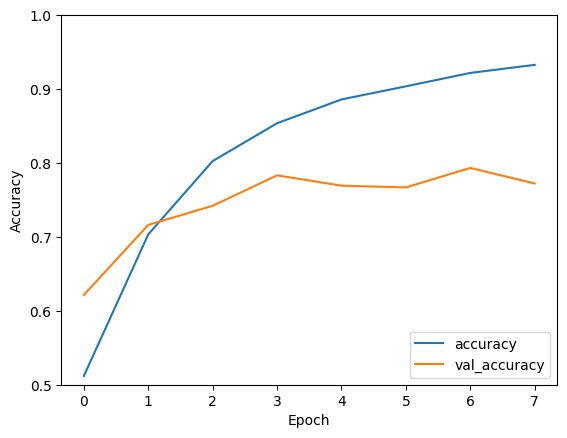

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = simpleCNN.evaluate(val_ds, verbose=2)

### We will reference the following article which provides remedies to overfit for CNN's. 
https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d 

The article recommends the following steps to reduce overfitting:
1. Add more data
2. Use data augmentation
3. Use architectures that generalize well
4. Add regularization (mostly dropout, L1/L2 regularization are also possible)
5. Reduce architecture complexity.



In [91]:
tweak1 = Sequential()
tweak1.add(Conv2D(32, (3,3), activation='relu', input_shape=(176, 208, 3)))
tweak1.add(BatchNormalization())
tweak1.add(MaxPooling2D((2,2)))
tweak1.add(Dropout(0.4))
tweak1.add(Conv2D(64, (3,3), activation='relu'))
tweak1.add(BatchNormalization())
tweak1.add(MaxPooling2D((2,2)))
tweak1.add(Dropout(0.4))
#tweak1.add(Conv2D(64, (3,3), activation='relu'))

#add dense layers
tweak1.add(Flatten())
tweak1.add(Dense(250, activation='relu'))
tweak1.add(BatchNormalization())
tweak1.add(Dropout(0.2))
tweak1.add(Dense(4, activation='softmax'))

tweak1.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 174, 206, 32)      896       
                                                                 
 batch_normalization_30 (Bat  (None, 174, 206, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 87, 103, 32)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 87, 103, 32)       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 85, 101, 64)       18496     
                                                                 
 batch_normalization_31 (Bat  (None, 85, 101, 64)    

In [92]:
tweak1.compile(optimizer='adam', loss = CategoricalCrossentropy(), metrics=['accuracy'])
history = tweak1.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25


2023-04-19 12:30:41.374039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


850/850 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.5784

2023-04-19 12:33:43.802786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


850/850 [==============================] - 196s 230ms/step - loss: 0.9739 - accuracy: 0.5784 - val_loss: 7.0818 - val_accuracy: 0.4612
Epoch 2/25
850/850 [==============================] - 197s 232ms/step - loss: 0.7577 - accuracy: 0.6710 - val_loss: 0.7922 - val_accuracy: 0.6541
Epoch 3/25
850/850 [==============================] - 194s 228ms/step - loss: 0.5984 - accuracy: 0.7471 - val_loss: 1.7641 - val_accuracy: 0.5427
Epoch 4/25
850/850 [==============================] - 193s 227ms/step - loss: 0.4848 - accuracy: 0.7977 - val_loss: 0.8653 - val_accuracy: 0.7863
Epoch 5/25
850/850 [==============================] - 190s 224ms/step - loss: 0.4032 - accuracy: 0.8354 - val_loss: 0.4153 - val_accuracy: 0.8337
Epoch 6/25
850/850 [==============================] - 189s 223ms/step - loss: 0.3390 - accuracy: 0.8646 - val_loss: 0.6212 - val_accuracy: 0.8324
Epoch 7/25
850/850 [==============================] - 194s 229ms/step - loss: 0.2683 - accuracy: 0.8938 - val_loss: 0.3447 - val_accura

In [93]:
# going to run a few more epochs to see if we can improve
history2 = tweak1.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
850/850 [==============================] - 195s 229ms/step - loss: 0.0329 - accuracy: 0.9882 - val_loss: 0.4386 - val_accuracy: 0.8724
Epoch 2/5
850/850 [==============================] - 193s 227ms/step - loss: 0.0342 - accuracy: 0.9878 - val_loss: 0.4340 - val_accuracy: 0.8852
Epoch 3/5
850/850 [==============================] - 193s 227ms/step - loss: 0.0391 - accuracy: 0.9866 - val_loss: 0.3927 - val_accuracy: 0.8870
Epoch 4/5
850/850 [==============================] - 195s 229ms/step - loss: 0.0349 - accuracy: 0.9876 - val_loss: 0.4336 - val_accuracy: 0.8849
Epoch 5/5
850/850 [==============================] - 194s 228ms/step - loss: 0.0351 - accuracy: 0.9872 - val_loss: 0.4329 - val_accuracy: 0.8773


213/213 - 14s - loss: 0.4329 - accuracy: 0.8773 - 14s/epoch - 63ms/step


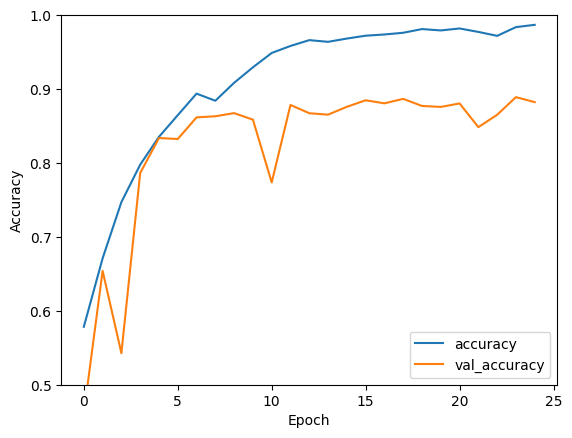

In [96]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = tweak1.evaluate(val_ds, verbose=2)

## Iterations

1. removed 3rd convolutional layer as well as dense 64 layer to reduce complexity. 
- result: still overfit, lower training and validation accuracy

2. added batchnormalization layers after each convolution layer as seen in online examples. 
- Result: increase to 81% accuracy on validation (only 5 epochs)
- Idea: maybe reduce batch size, will increase train time but could help prevent generalization error

3. changed activation back to relu, batch size reduced to 16
- result: BAD, total random guess, 26% accuracy

4. adding dropout, changed input dimensions to 176x208
- results: accuracy at 85% after 13 epochs, overfit begins after 13 epochs

5. adding another dense layer before the output, with dropout in between
- upped dense layer units to 250, added batchnorm

